### Denoising Diffusion Probablisic Models on MNIST digis

In [ ]:
!git clone https://github.com/Daisuke0713/ANN-final.git
%cd ./ANN-final/DDPMs

#### Libraries

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm
from tensorflow import keras

# U-Net
from u_net import Unet

#### GPU/CPU

In [71]:
gpu_device = tf.test.gpu_device_name()
cpu_device = '/cpu:0'
device = cpu_device

#### Hyper-parameters

In [72]:
# hyperparams
image_size = (32, 32)
num_channel = 1
batch_size = 64
timesteps = 200
learning_rate = 1e-4
epochs = 10

#### Data pre-processing

In [73]:
# get and preprocess dataset
dataset = tfds.load('mnist', as_supervised=True, split="train")
dataset = dataset.map(lambda x, _: tf.image.resize(tf.cast(x, tf.float32) / 127.5 - 1, image_size), tf.data.AUTOTUNE)
dataset = dataset.shuffle(5000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
dataset = tfds.as_numpy(dataset)

#### Forward Pass

#### 1. Define Forward Pass
The forward pass $q$ follows a Markov Chain of $T > 0$ time steps. Given an initial image $x_{0}$, $q$ adds a noise defined by Gaussian with pre-determined variance $\beta_{t}$ at each time stamp $t \leq T$. Consequently, we can define the forward process: $$q(x_{t}|x_{t-1}) = \mathcal{N}(x_{t}; \sqrt{1-\beta_{t}}\cdot x_{t-1}, \beta_{t}).$$ The probability for a chain to occur from $x_1$ to $x_t$ can be obtained by Markov chains: $$q(x_{1:T}|x_{0}) = \prod_{t=1}^{T}q(x_t|x_{t-1}).$$ In order to avoid the recursive process of adding noise to a preivous image at each time stamp, we use the reparameterization trick given by
$$q(x_{t}|x_{0}) = \mathcal{N}(x_{t}; \sqrt{\hat{\alpha_{t}}}\cdot x_{0}, 1-\hat{\alpha_{t}}),$$
where $a_{t} := 1 - \beta_{t}$ and $\hat{\alpha_{t}} := \prod{\alpha_{i}}.$ Finally, the resulting $x_t$ can be obtained by $$x_{t} = \mu_{q} + \sigma_{q} \cdot z,$$
where $z \sim \mathcal{N}(0,1)$.

In [74]:
# define forward pass
beta = np.linspace(0.0001, 0.02, timesteps)
alpha = 1 - beta
a = np.concatenate((np.array([1.]), np.cumprod(alpha, 0)[:-1]), axis=0) # alpha bar

def forward(x_0, t):
    with tf.device(device):
        noise_t = np.random.normal(size=x_0.shape)
        sqrt_a_t = np.reshape(np.take(np.sqrt(a), t), (-1, 1, 1, 1))
        sqrt_one_minus_a_t = np.reshape(np.take(np.sqrt(1-a), t), (-1, 1, 1, 1))
        x_t = sqrt_a_t  * x_0 + sqrt_one_minus_a_t  * noise_t
        return noise_t, x_t

def generate_timestamp(num):
    return tf.random.uniform(shape=[num], minval=0, maxval=timesteps, dtype=tf.int32)

#### 2. Visualize the forward process on five samples

2023-04-24 22:19:35.125814: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


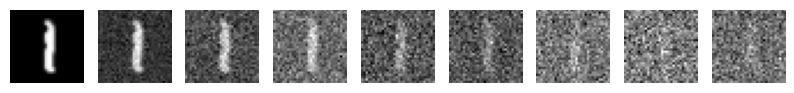

In [118]:
# visualize forward pass
def forward_and_show_progress(x_0, steps):
    plt.figure(figsize=(10,4))
    for i, t in enumerate(steps):
        _, x_t = forward(np.expand_dims(x_0, 0), np.array([t,]))
        plt.subplot(1, 9, i+1)
        plt.imshow(np.squeeze(np.squeeze(x_t,-1),0), cmap='gray')
        plt.axis('off')
    plt.show()
    return x_t

x_0 = next(iter(dataset))[0]
x_t = forward_and_show_progress(x_0, [0,25,50,75,100,125,150,175,199])


### Reverse (denoising) Pass using U-Net

#### 1. Define U-Net for denoising
Our U-Net incorporates attention layers, ResNet, and time embedding layers for a better performance.

In [76]:
# create our unet model
unet = Unet()

# create our checkopint manager
ckpt = tf.train.Checkpoint(unet=unet)
ckpt_manager = tf.train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=1)

# build/compile the model in the memory with dummy input
dummy = unet(np.ones([1, 32, 32, 1]), generate_timestamp(1))

# load from a previous checkpoint if it exists, else initialize the model from scratch
ckpt.restore(ckpt_manager.latest_checkpoint)
start_interation = int(ckpt_manager.latest_checkpoint.split("-")[-1])
ckpt.restore('./checkpoints/ckpt-8')

#### 2. Loss
Our loss can be computed using MSE given by
$$\text{loss}(\theta) = ||\epsilon_{\theta} - \epsilon||_{2}^{2},$$
where $\epsilon$ is a noise randomly sampled during the forward pass.

In [77]:
# define the loss
def loss(noise, predicted):
    with tf.device(device):
        return tf.math.reduce_mean((noise-predicted)**2)

#### 3. Define the train process of U-Net

In [79]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
def train_step(train_images):
    with tf.device(device):
        # create a "batch" number of random timesteps (in our case 64)
        timestep_values = tf.random.uniform(shape=[train_images.shape[0]], minval=0, maxval=timesteps, dtype=tf.int32)
        
        # forward 
        noised_images, noise = forward(x_0=train_images, t=timestep_values)

        # set the gradient and get the prediction
        with tf.GradientTape() as tape:
            predicted = unet(x=noised_images, time=timestep_values)
            loss_value = loss(noise, predicted)

        # optimize U-Net using ADAM
        gradients = tape.gradient(loss_value, unet.trainable_variables)
        optimizer.apply_gradients(zip(gradients, unet.trainable_variables))

    return loss_value

def train(epochs):
    with tf.device(device):
        # train a number of epochs time
        for epoch in range(epochs):
            losses = []
            progress = tf.keras.utils.Progbar(len(dataset)-1)
            for i, batch_images in enumerate(iter(dataset)):
                loss = train_step(batch_images)
                losses.append(loss)
                progress.update(i, values=[("loss", loss)])

            print(f'Epoch: {epoch}, Loss: {np.mean(losses)}')
            ckpt_manager.save(checkpoint_number=epoch)


#### 4. Train our U-Net (only if you would liuke to train from scratch)
Note that training U-Net can take very long depending on your processor. Using Google Colab's Premium GPU (NVIDIA-SMI Persistence-M), which is x100 faster than CPUs on MAC Pro, training for 10 epochs takes roughly 2 hours.

In [80]:
# train
# train(epochs=epochs)

# zip the checpoint
# !zip -r ./checkpoints.zip checkpoints

#### 5. Define Backward Pass (Denoising)
The backward pass from $x_{T}$ to $x_{T-1}$ uses the noise $\epsilon_{\theta}$ predicted by U-Net, and the denoised $x_{T-1}$ can be ontained by reversing the forward pass we preivously computed as follows: $$x_{T-1} = \frac{1}{\sqrt{\alpha_{T}}}\left(x_{T}-\frac{1-\alpha_{T}}{\sqrt{1-\bar{\alpha_T}}} \cdot \epsilon_{\theta} \right) + \sqrt{\beta_{t}}\cdot z,$$
where $z \sim \mathbb{N(0,1)}$.

In [81]:
def denoise_x(x_t, pred_noise, t):
    with tf.device(device):
        # obtain variables
        alpha_t = np.take(alpha, t)
        a_t = np.take(a, t)

        # calculate denoised_x (i.e., x_{t-1})
        beta_t = np.take(beta, t)
        z = np.random.normal(size=x_t.shape)
        denoised_x = (1/np.sqrt(alpha_t)) * (x_t - ((1-alpha_t)/np.sqrt(1-a_t))*pred_noise) + np.sqrt(beta_t) * z
        return denoised_x

def backward(x, i):
    with tf.device(device):
        t = np.expand_dims(np.array(timesteps-i-1, np.int32), 0)
        pred_noise = unet(x, t)
        return denoise_x(x, pred_noise, t)

### Inference

Our sampling in the inference looks as follows:
1. Sample a standard Gaussian $x_T$ (the noisy image) from $\mathcal{N}(0,1)$.
2. Use U-Net to predict the added noise $\epsilon_{\theta}$.
3. Use $\epsilon_{\theta}$ and $X_{T}$ to perform the backward pass to obtain $X_{T-1}$.
4. Repeat 2 and 3 for every timestamp $t > 1$.

In [123]:
def get_sample(x=None, show_progress=True):
    # generate noise
    if x is None:
        x = tf.random.normal(shape=(1,32,32,1))

    # array to store images
    imgs = [np.squeeze(np.squeeze(x, 0),-1)]

    # backward process
    for i in tqdm(range(timesteps-1)):
        x = backward(x, i)
        if i in [0,25,50,75,100,125,150,175,198]:
            imgs.append(np.squeeze(np.squeeze(x, 0),-1))

    return imgs if show_progress else imgs[-1]

def backward_and_show_progress(x=None, save_img=True, n=None):
    # generate images
    generated_imgs = get_sample(x)
    # save images
    plt.figure(figsize=(10,4))
    for i in range(9):
        plt.subplot(1, 9, i+1)
        plt.imshow(generated_imgs[i], cmap='gray')
        plt.axis('off')
    if save_img:
        plt.savefig(f'./generated_images/sample{n}.png')
    else:
        plt.show()

In [ ]:
for i in range(10):
    backward_and_show_progress(n=i)

#### Forward vs Backward Pass

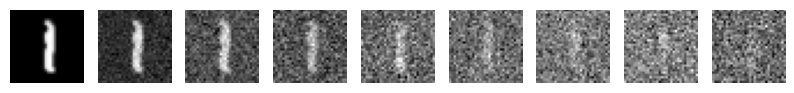

In [119]:
# forward pass
x_t = forward_and_show_progress(x_0, [0,25,50,75,100,125,150,175,199])

100%|██████████| 199/199 [00:44<00:00,  4.52it/s]


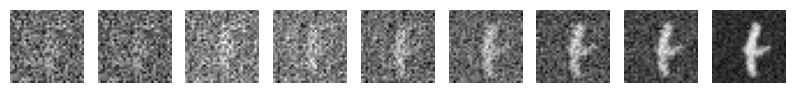

In [120]:
# backward pass
backward_and_show_progress(x=x_t, save_img=False)